In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.utils.dynamical_systems import Lorenz63
import adjoint_esn.utils.solve_ode as solve_ode
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils import errors
import adjoint_esn.utils.lyapunov as lyap
from adjoint_esn.utils import visualizations as vis
from adjoint_esn.esn import ESN
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils import errors,scalers
from adjoint_esn.validation import validate
from adjoint_esn.validation import set_ESN
import yaml
from pathlib import Path


## Generate data

In [10]:
# simulation options
sim_time = 300
sim_dt = 1e-3

# system parameters
INIT_beta_list = [4/3,5/3,6/3,7/3,8/3]
INIT_rho_list = [30,35,40,45,50]
INIT_sigma_list = [10,11,12,13,14]
eParam = Lorenz63.get_eParamVar()
param_list = [None]*3
param_list[eParam.beta] = INIT_beta_list
param_list[eParam.rho] = INIT_rho_list
param_list[eParam.sigma] = INIT_sigma_list
train_param_list = pp.make_param_mesh(param_list)

train_idx_list=[0,2,4]
val_idx_list=[1,3]

transient_time = 20

# network time step
network_dt = 1e-2

washout_time = 4

# length of training time series
train_time = 50
# length of validation time series
validation_time = 100
# can add test, then add it in the loop_names and loop_times
test_time = 10

In [11]:
loop_names=['train','val']
loop_times = [train_time, validation_time]

DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(train_param_list):
    params = {"beta": p[Lorenz63.get_eParamVar()["beta"]],
              "rho": p[Lorenz63.get_eParamVar()["rho"]],
              "sigma": p[Lorenz63.get_eParamVar()["sigma"]]}
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=0)

    regime_data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=["x","y","z"],
                        param_vars=["rho"],
                        loop_times=loop_times,
                        loop_names=loop_names)
    
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]

# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]

Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.
Running solver.


### Plot data

C:\Users\egeoz\AppData\Local\Temp\ipykernel_14232\2529355595.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (15,3),constrained_layout=True)


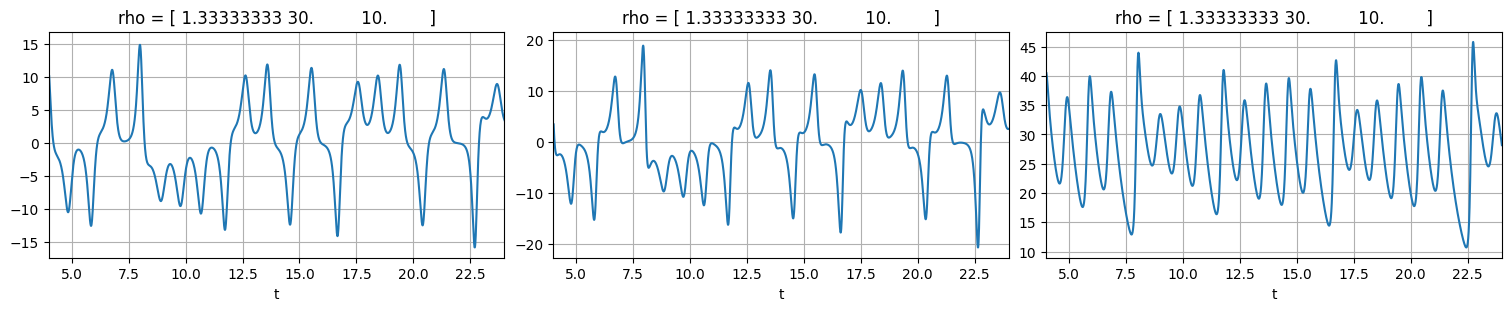

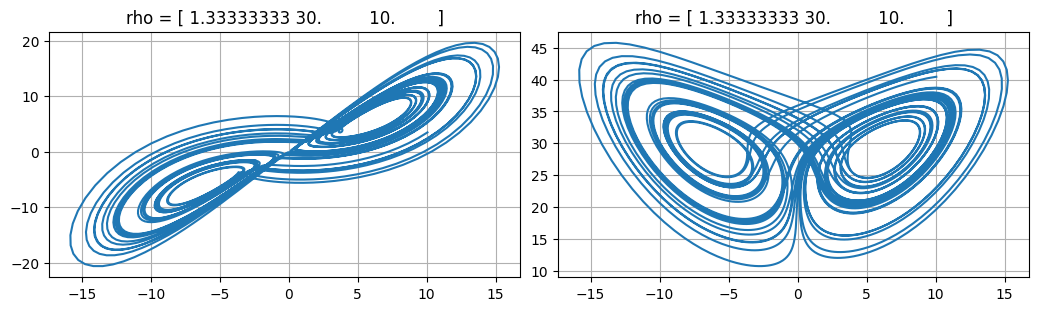

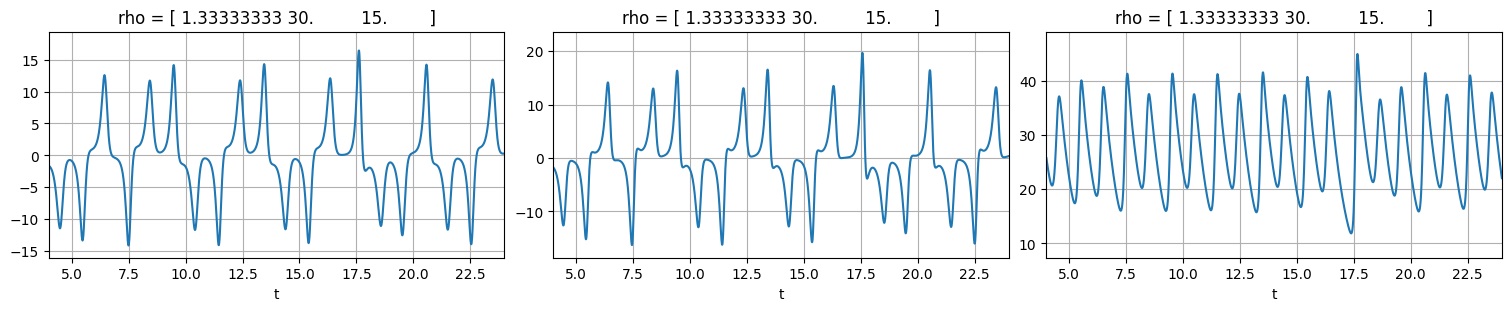

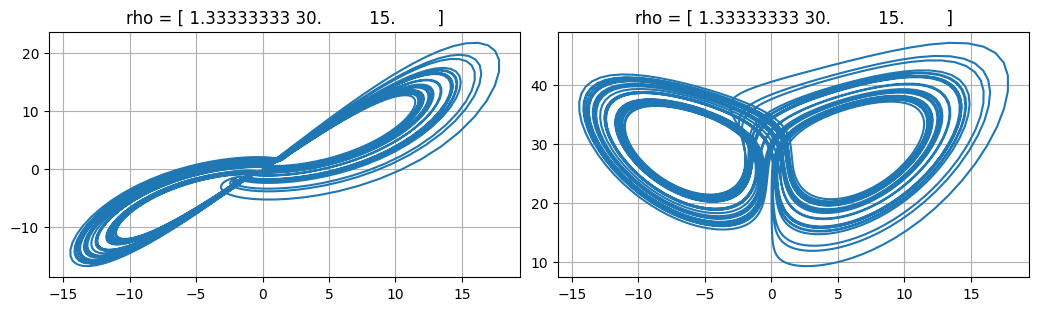

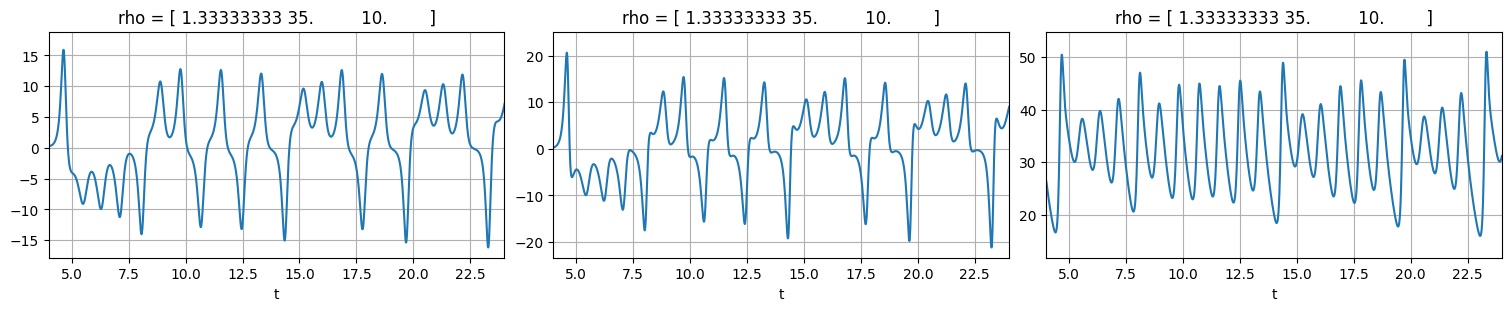

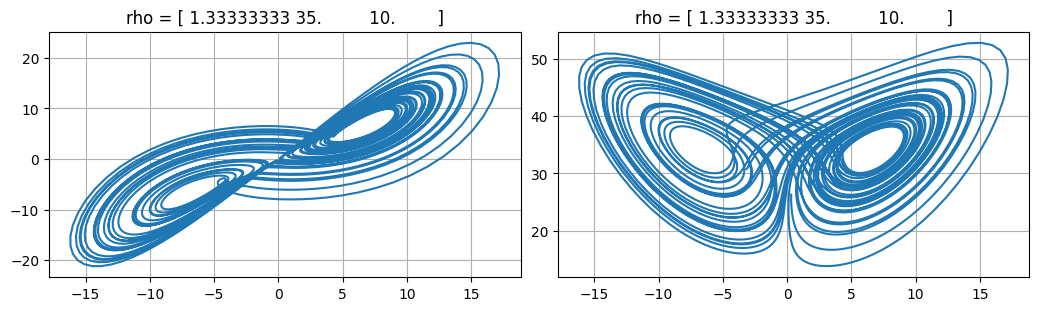

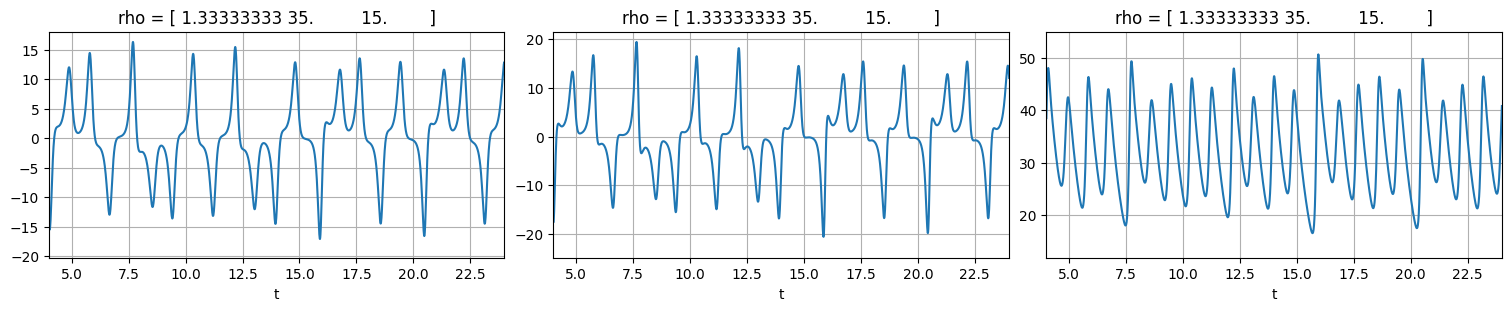

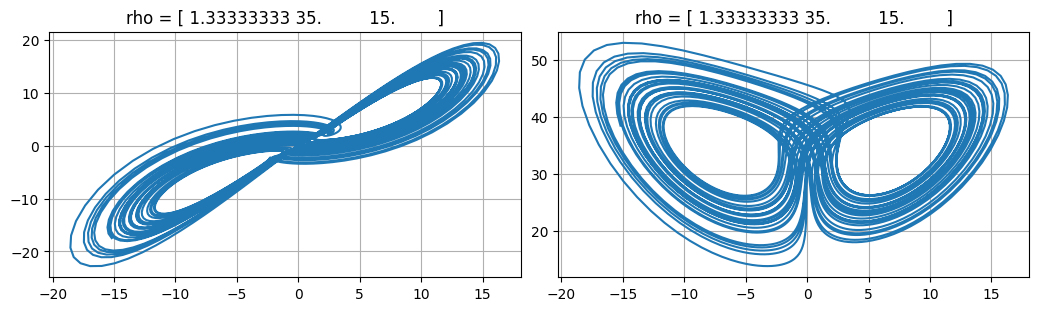

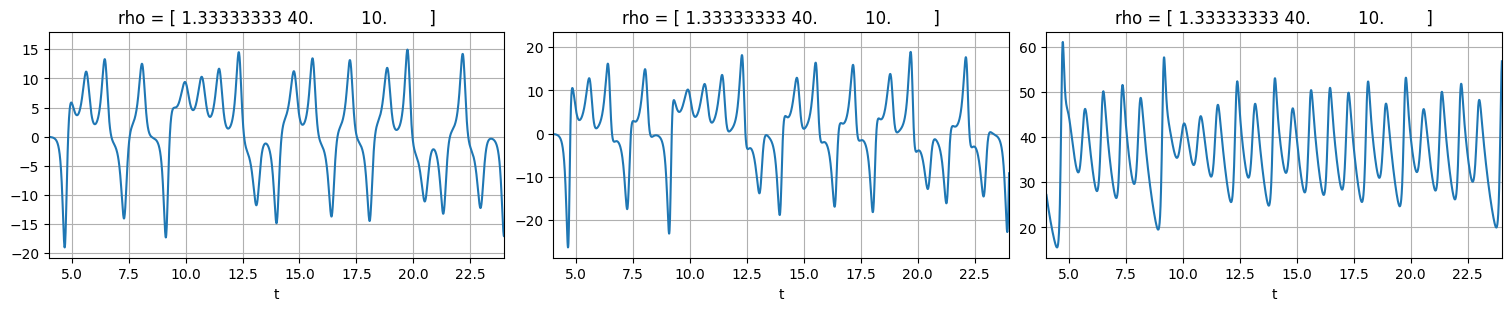

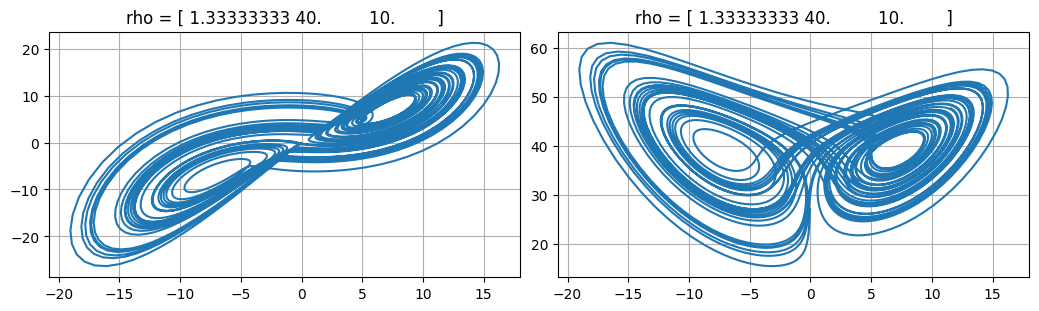

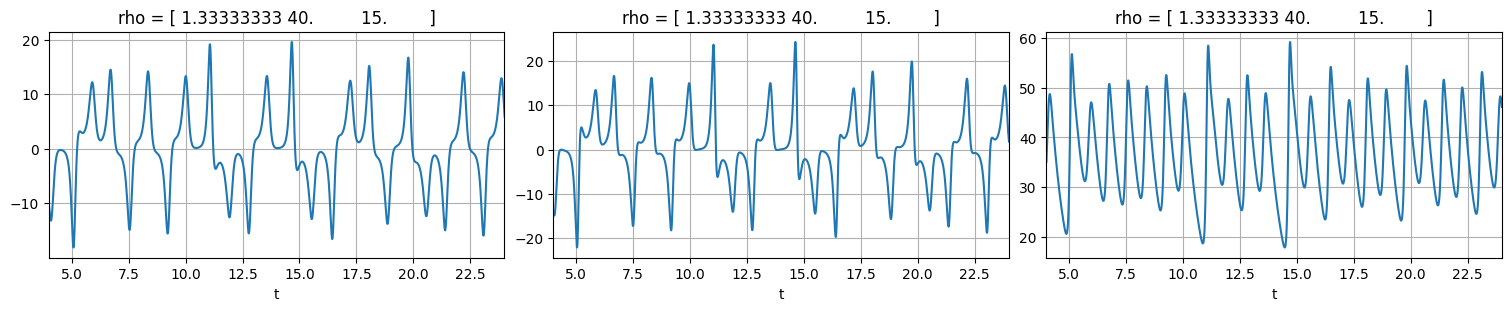

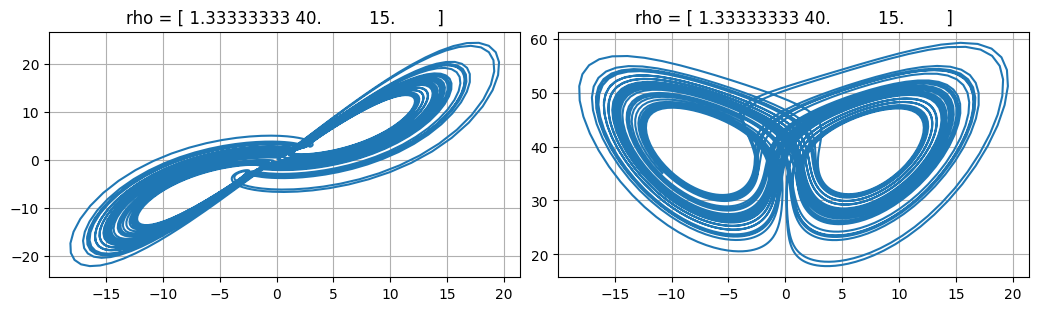

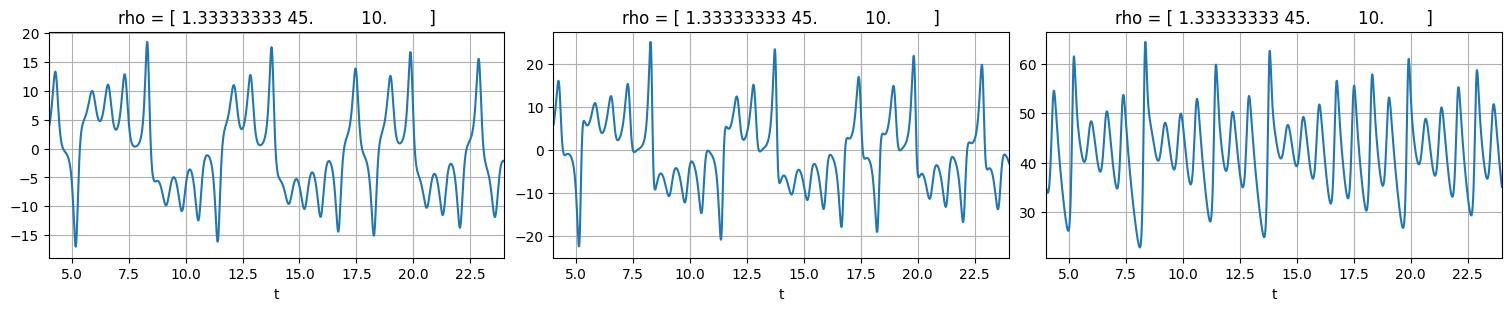

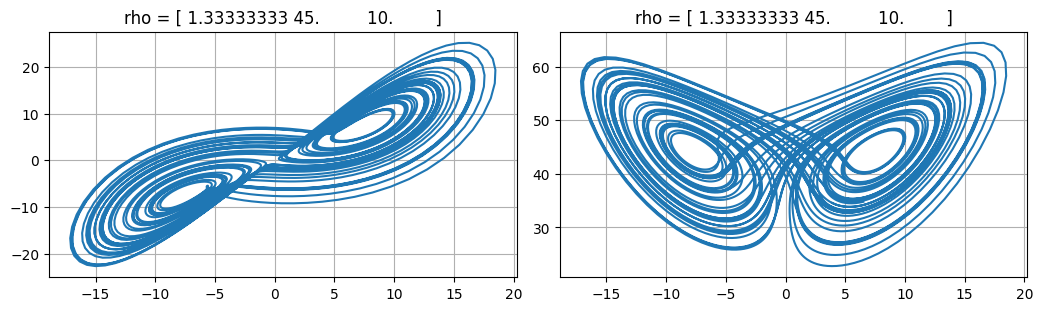

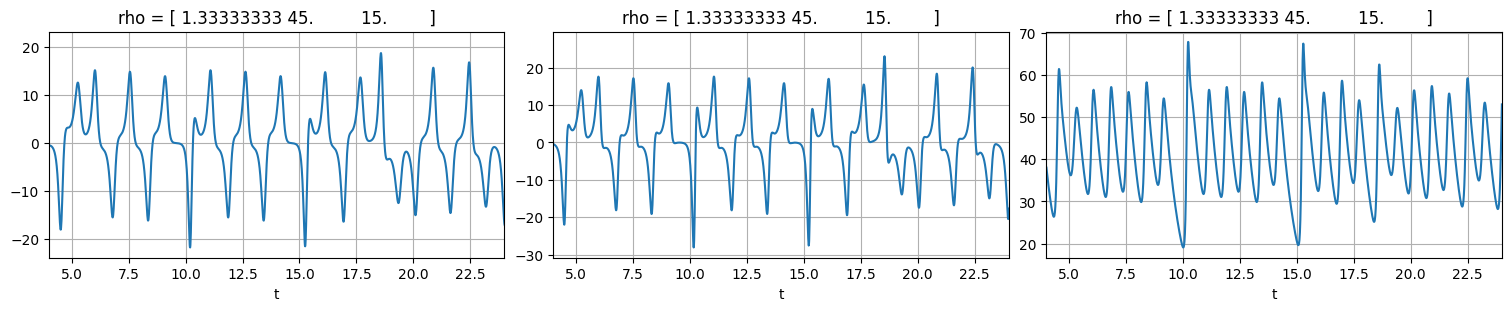

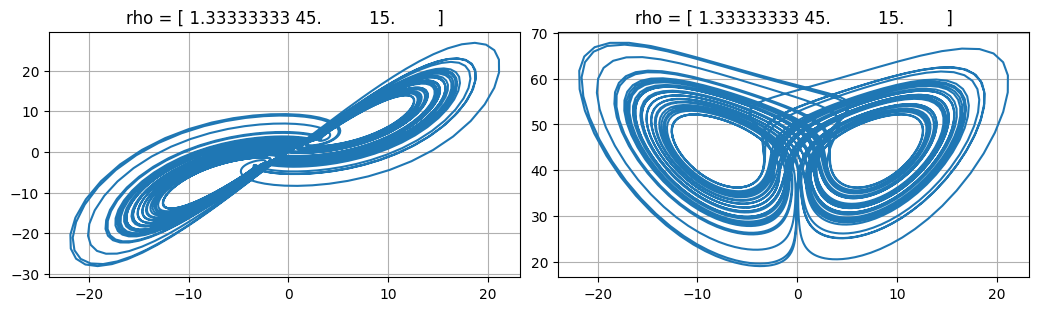

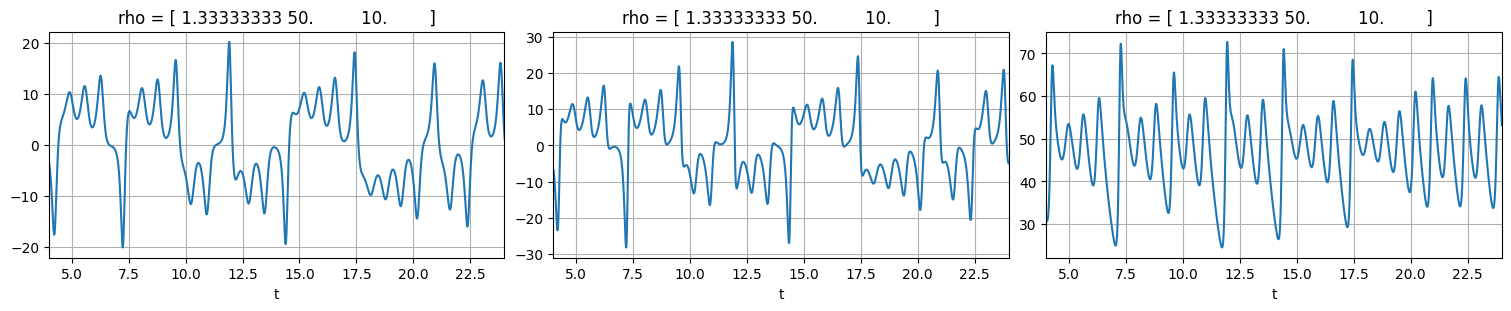

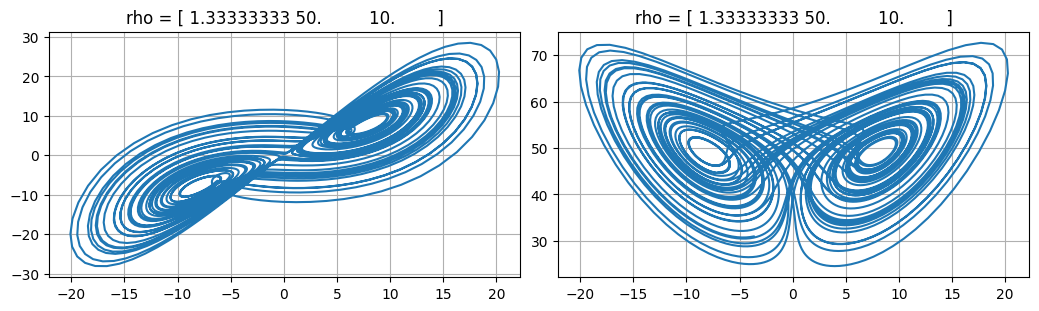

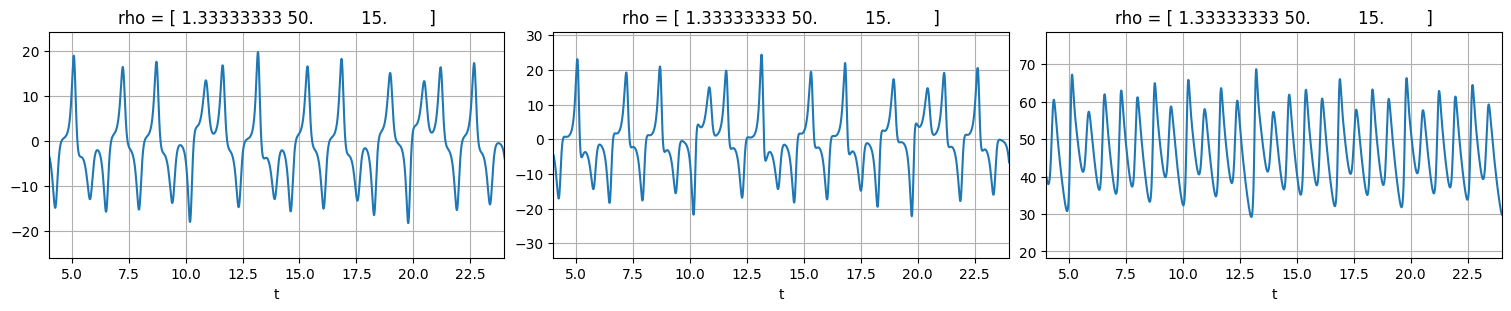

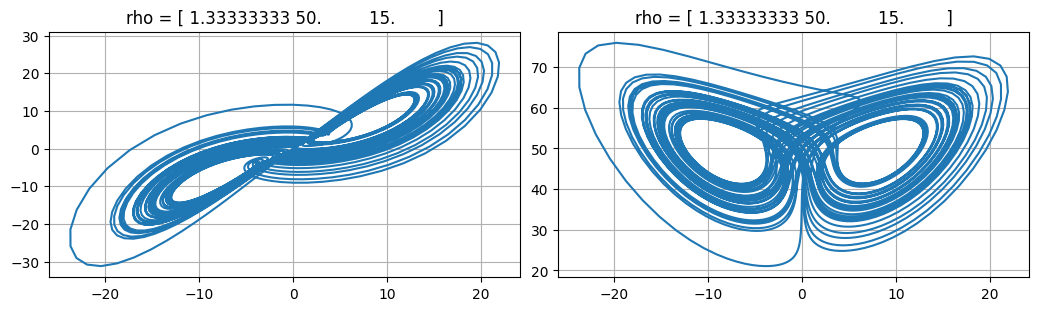

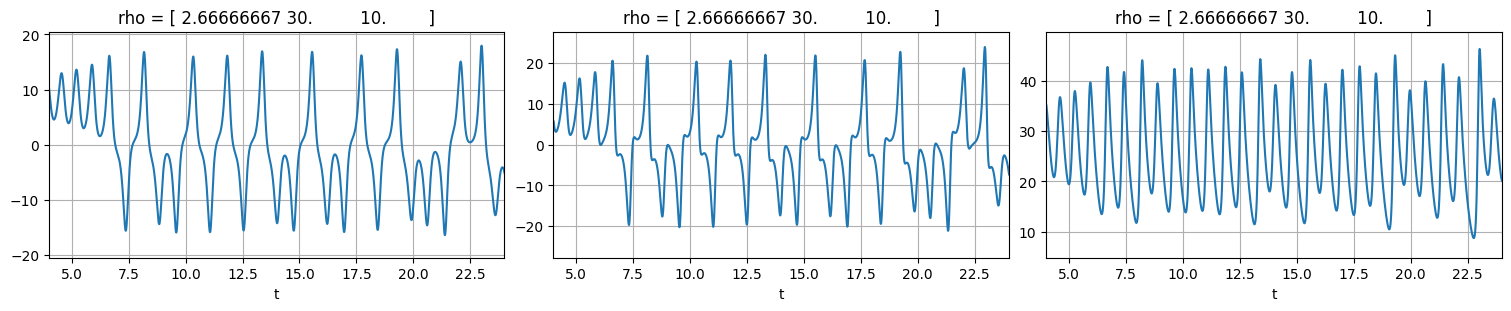

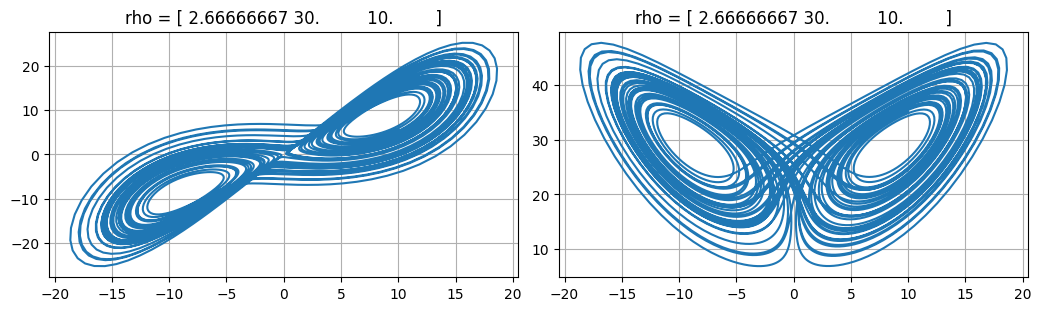

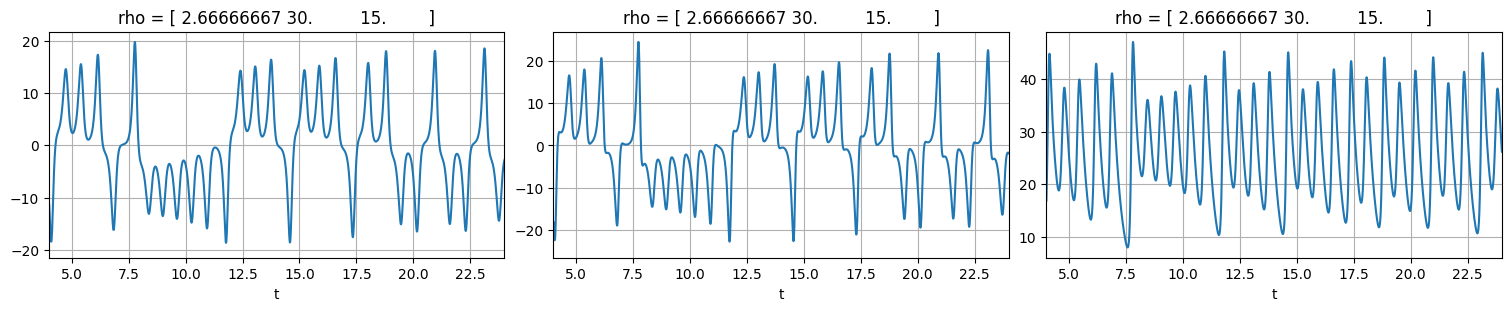

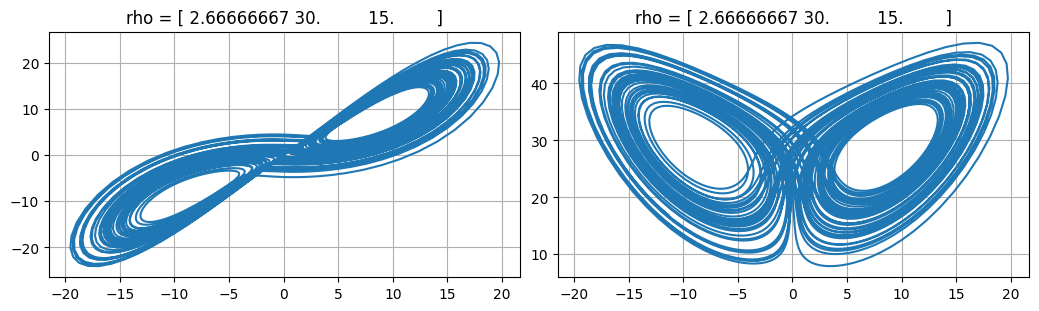

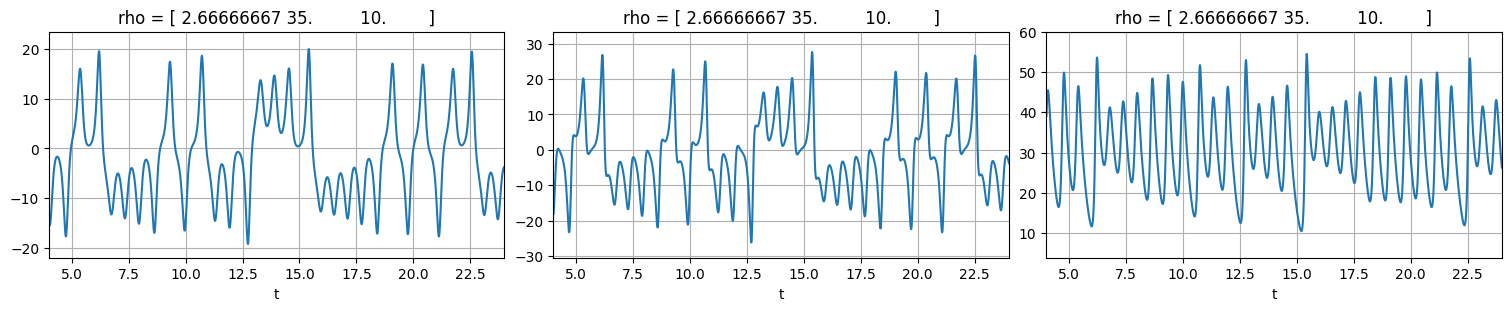

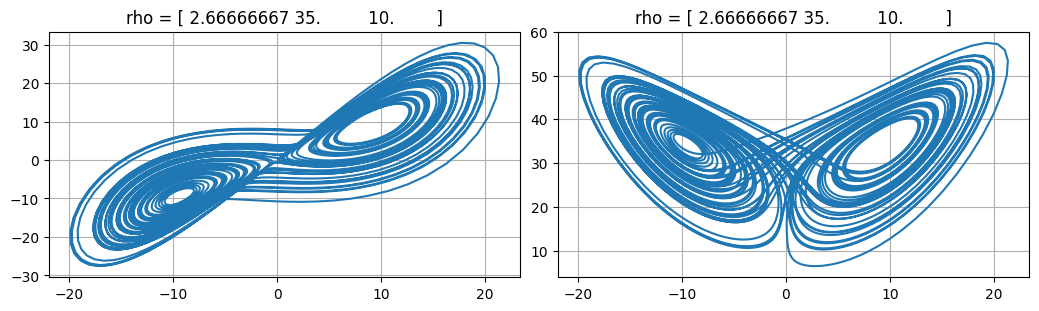

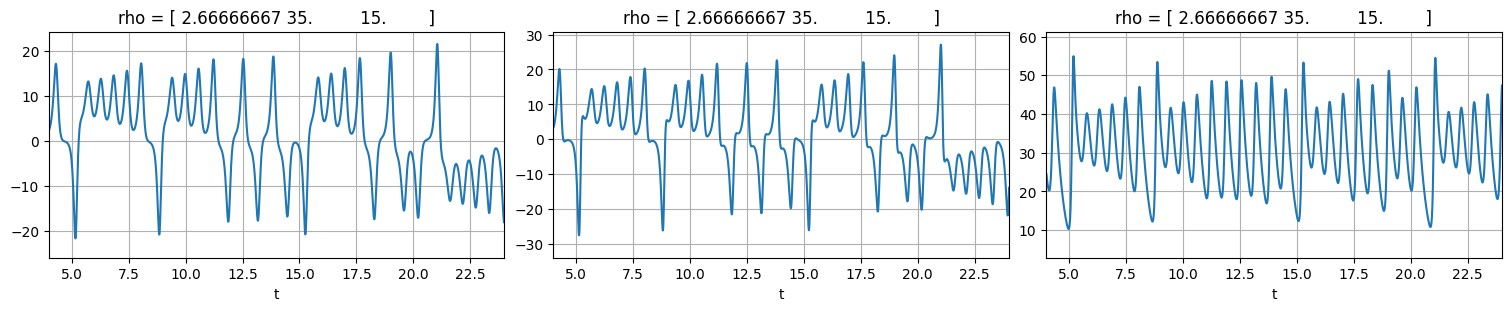

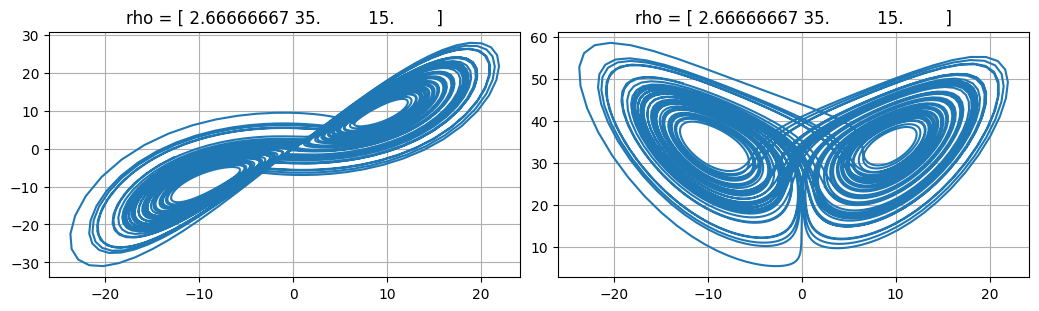

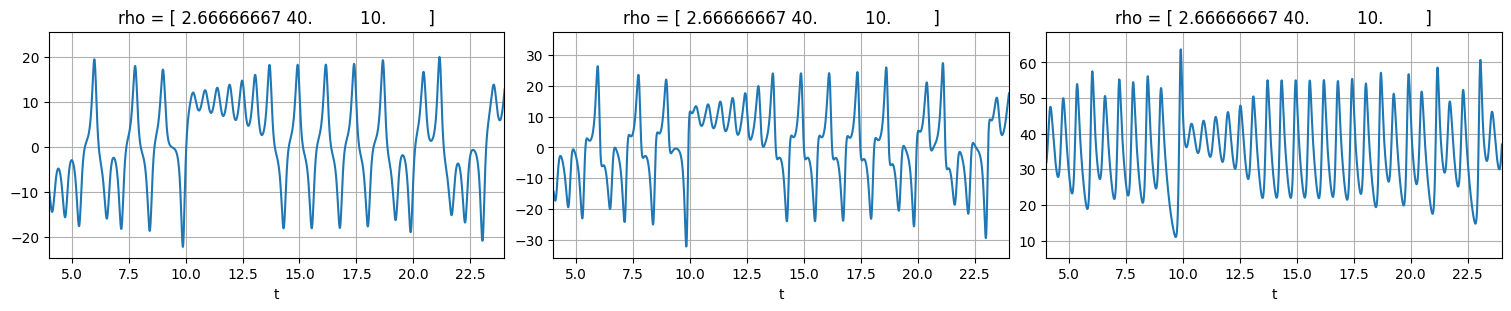

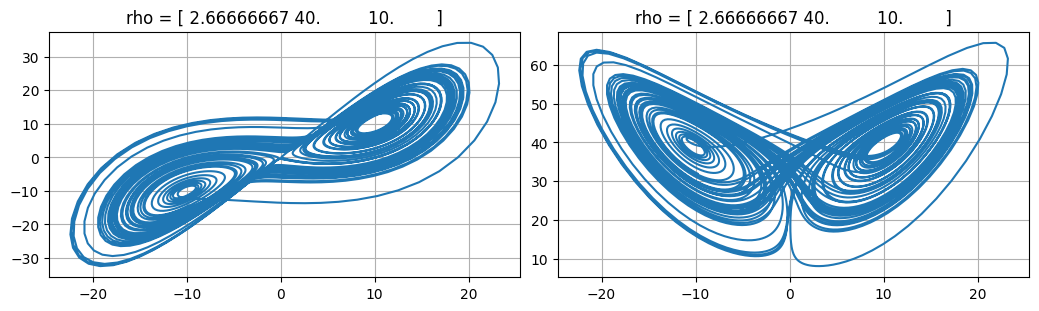

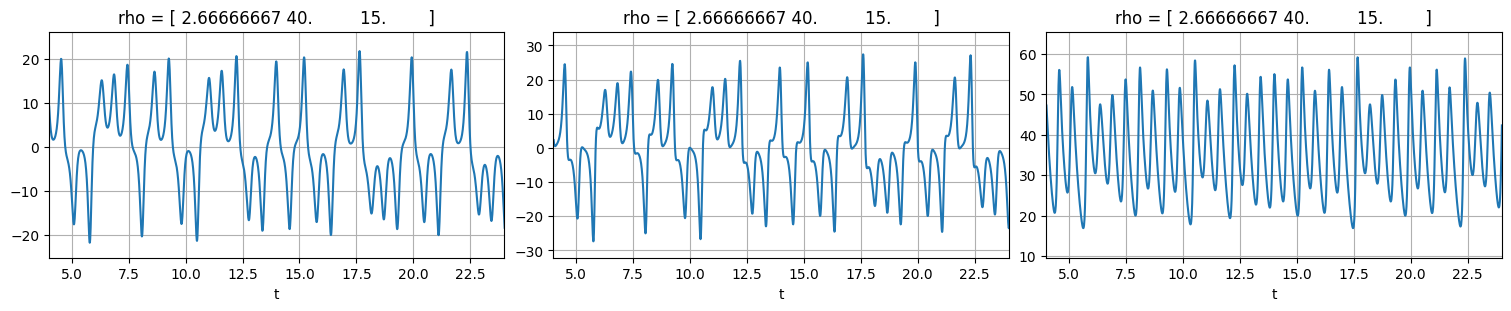

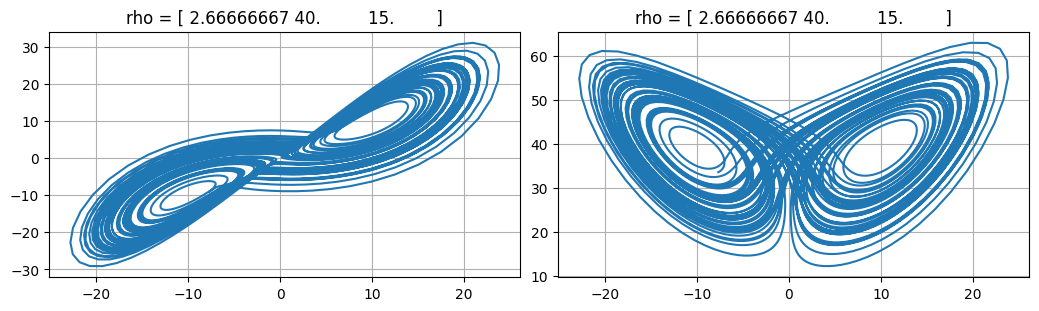

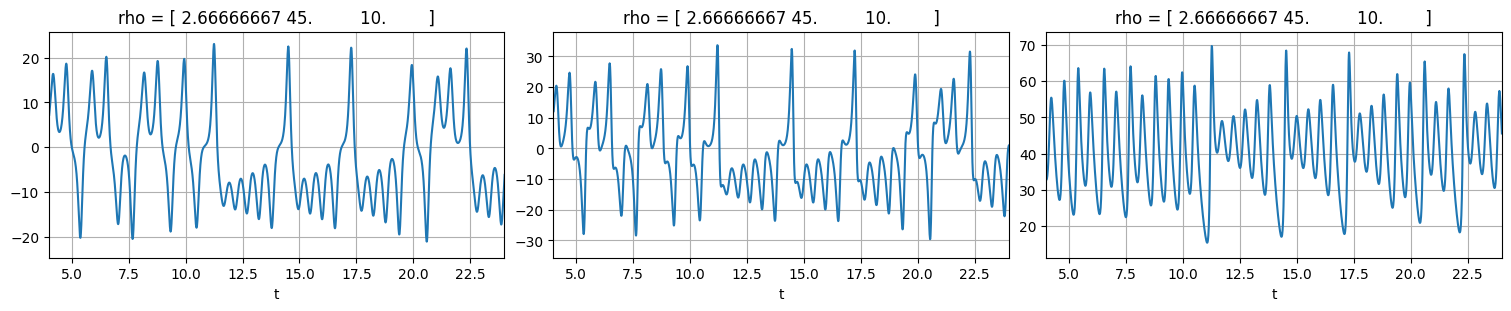

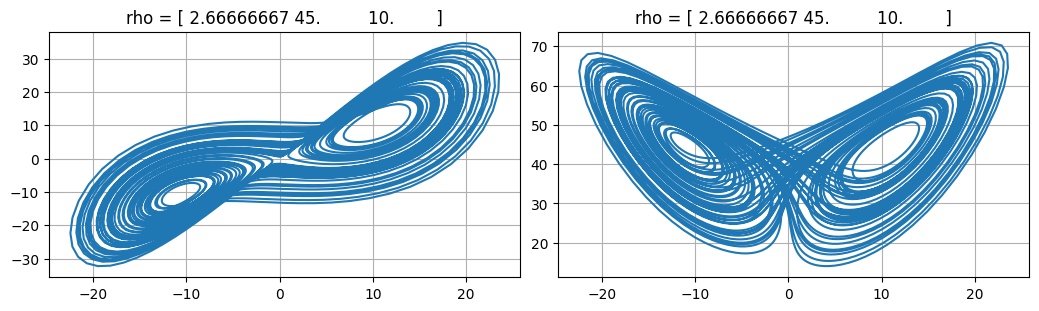

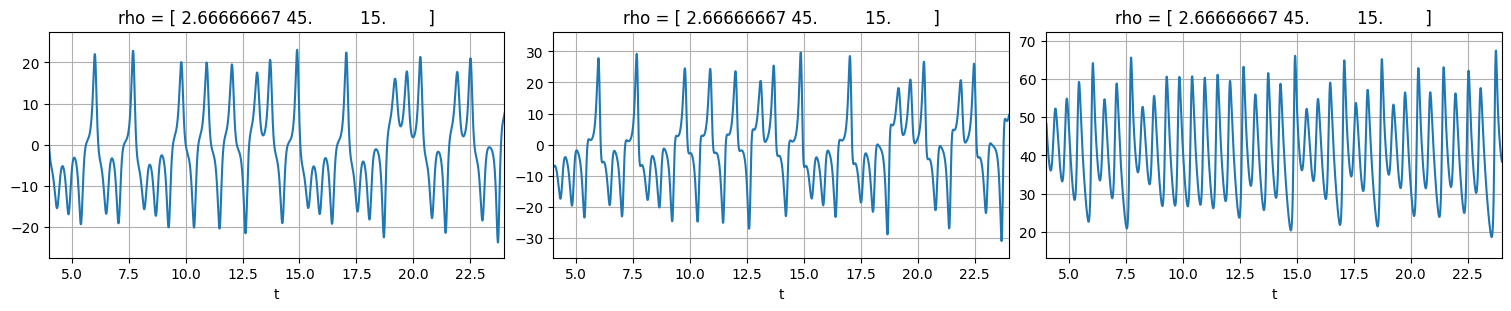

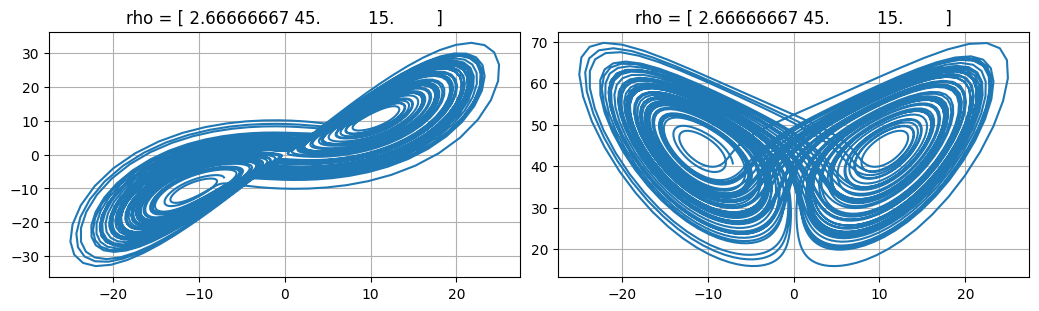

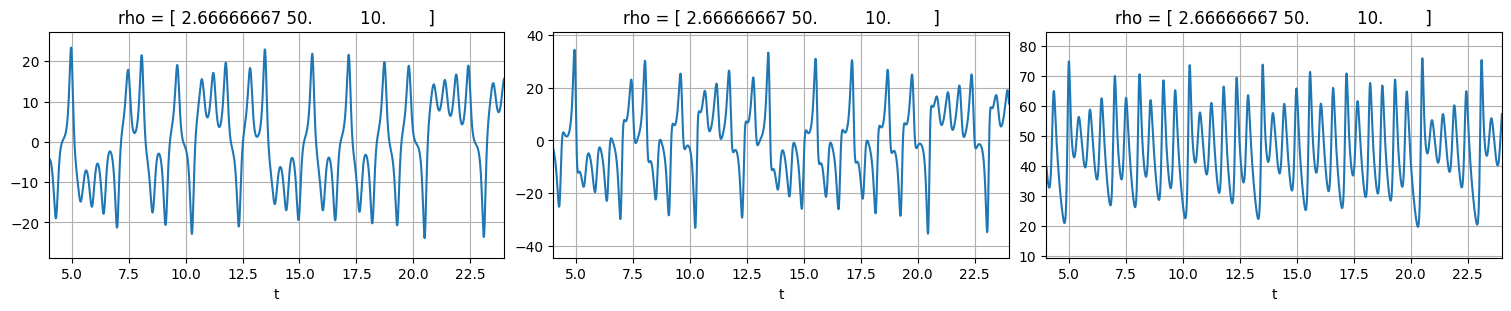

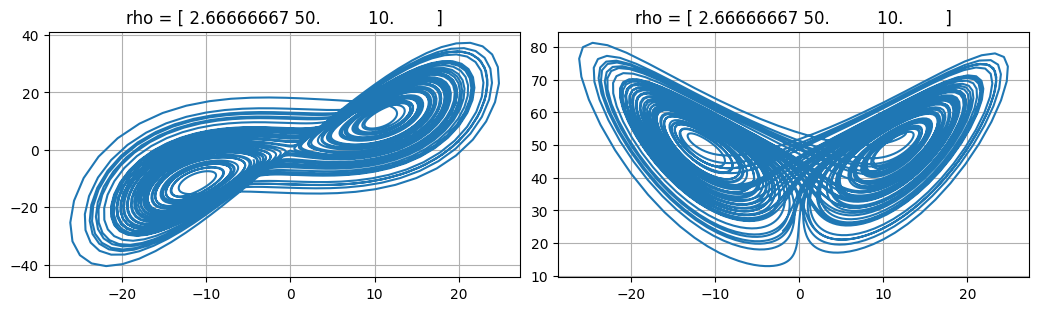

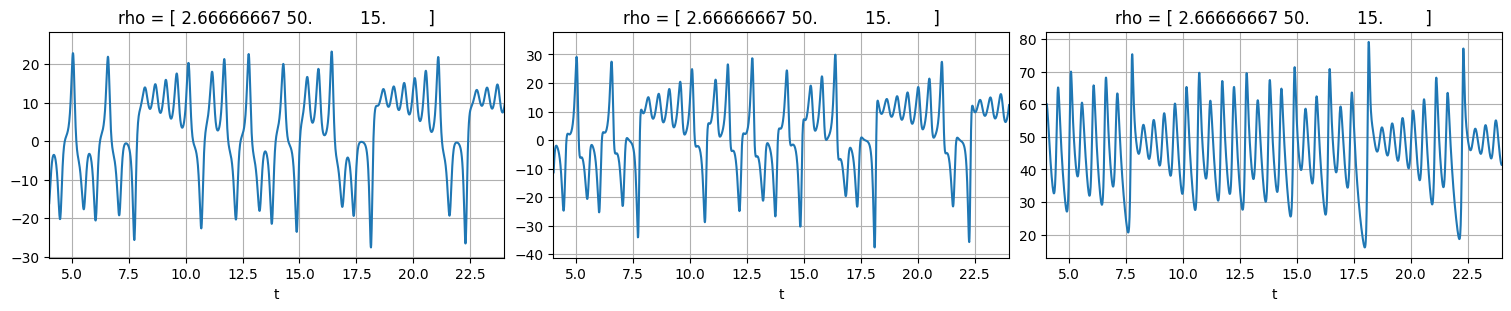

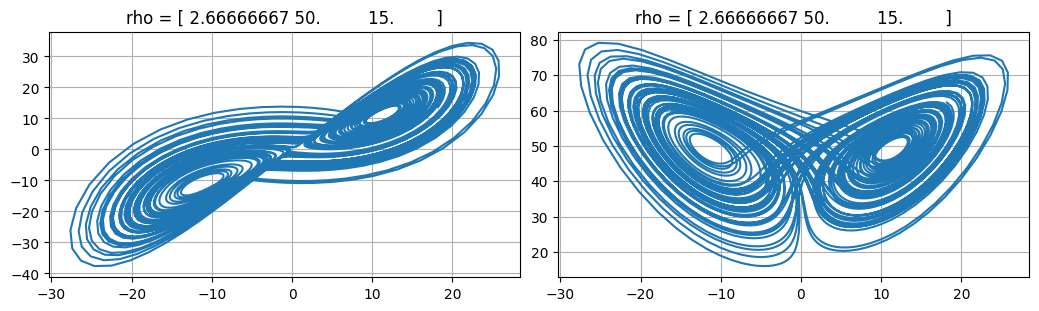

In [12]:
len_p_list=len(train_param_list)
plt_idx = [0,1,2]
plt_idx_pairs = [[0,1],
                 [0,2],]
for p_idx in np.arange(len_p_list):
    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        vis.plot_lines(DATA["train"]["t"][p_idx],DATA["train"]["u"][p_idx][:,k],
                   title=f"rho = {train_param_list[p_idx]}",
                   xlabel='t')
        plt.xlim([washout_time,20+washout_time])

    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx_pairs):
        plt.subplot(1,len(plt_idx),j+1)
        vis.plot_phase_space(DATA["train"]["u"][p_idx],
                            idx_pair=k,
                            title=f"rho = {train_param_list[p_idx]}")

## Hyperparameter search

In [51]:
from adjoint_esn.validation import validate as validate_v2

# hyperparameter names, should match the attributes of ESN
hyp_param_names = ['input_scaling','spectral_radius','leak_factor','parameter_normalization_mean','parameter_normalization_var','tikhonov']

# range for hyperparameters 
spec_in     = 0.01
spec_end    = 1.0
in_scal_in  = 0.01
in_scal_end = 10.0
u_f_scal_in  = 1.0
u_f_scal_end = 2.0
leak_in     = 0.1    
leak_end    = 1.0
param_var_in = 0.001
param_var_end = 10.0
param_mean_in = -30.0
param_mean_end = 30.0
tikh_in = 1e-8
tikh_end = 1e-1
grid_range = [[in_scal_in, in_scal_end],
              [spec_in, spec_end],
              [leak_in, leak_end],
              [param_mean_in, param_mean_end],
              [param_var_in, param_var_end],
              [tikh_in, tikh_end]]

# scales, uniform or log10
hyp_param_scales = ['log10','log10','log10','uniform','log10','log10']

# scale the ranges
for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, hyp_param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])
        
N_washout = int(np.round(washout_time/network_dt))
fold_time = 1
N_val = int(np.round(fold_time/network_dt))
N_transient = 0
reservoir_size = 300
connectivity = 3
ESN_dict = {'reservoir_size': reservoir_size, 
            'dimension' : dim, 
            'parameter_dimension' : 1,
            'reservoir_connectivity' : connectivity,
            'input_normalization': None, 
            'input_bias' : np.array([]),
            'output_bias' : np.array([]),
            'parameter_normalization': [np.array([0.0]),np.array([1.0])],
            'r2_mode': False,
            'input_weights_mode': "sparse_grouped",
            'reservoir_weights_mode': "erdos_renyi2",
            'input_only_mode': False,
            'tikhonov': 1e-1,
            }
min_dict = validate_v2(grid_range,hyp_param_names,hyp_param_scales,
    n_calls = 100, n_initial_points = 50,
    ESN_dict = ESN_dict, ESN_type = "standard",
    U_washout_train = DATA["train"]["u_washout"],
    U_train = DATA["train"]["u"],
    U_val = DATA["val"]["u"],
    Y_train = DATA["train"]["y"],
    Y_val = DATA["val"]["y"],
    P_washout_train = DATA["train"]["p_washout"],
    P_train = DATA["train"]["p"],
    P_val = DATA["val"]["p"],
    n_folds = 10,
    n_realisations=5,
    N_washout_steps = N_washout,
    N_val_steps = N_val,
    N_transient_steps = N_transient,
    train_idx_list=train_idx_list,
    val_idx_list=val_idx_list,
    p_list=train_param_list,
    n_grid = None,
    error_measure=errors.rel_L2)

--NEW RUN-- 1
Realisation: 0
input_scaling 0.07875596470213515
spectral_radius 0.09753935043347353
leak_factor 0.2773415559327119
parameter_normalization_mean 19.91468153827207
parameter_normalization_var 0.21542045941515145
tikhonov 1e-08


Val regime: 0
Val regime error: 563.16546873123
Val regime: 1
Val regime error: 368.4966876676249
Realisation error: 465.83107819942745


Realisation: 1
input_scaling 0.07875596470213515
spectral_radius 0.09753935043347353
leak_factor 0.2773415559327119
parameter_normalization_mean 19.91468153827207
parameter_normalization_var 0.21542045941515145
tikhonov 1e-08


Val regime: 0
Val regime error: 118.35705726456604
Val regime: 1
Val regime error: 129.51562103182434
Realisation error: 123.93633914819519


Realisation: 2
input_scaling 0.07875596470213515
spectral_radius 0.09753935043347353
leak_factor 0.2773415559327119
parameter_normalization_mean 19.91468153827207
parameter_normalization_var 0.21542045941515145
tikhonov 1e-08


Val regime: 0
Val regi

In [10]:
# reservoir_size = 300, connectivity = 3, res_idx = 1 seems to work better than 0
# {'f': array([0.01955057, 0.0233646 , 0.03104692, 0.04874041, 0.05695006]), 
#  'tikhonov': array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-07]), 
#  'input_scaling': array([0.06589674, 0.06092448, 0.10726563, 0.06116186, 0.29689916]), 
#  'leak_factor': array([0.75522845, 0.18122784, 0.35376061, 0.94379384, 0.56624207]), 
#  'parameter_normalization_mean': array([ 17.17972794, -23.1584059 ,  -8.80988332, -10.34529387,-28.94849621]), 
#  'parameter_normalization_var': array([0.00105302, 0.0114864 , 0.00643863, 0.00380511, 0.00562343]), 
#  'spectral_radius': array([0.56236475, 0.62486526, 0.07100306, 0.02115946, 0.04583864])}

# {'f': array([0.01576745, 0.02165784, 0.03608381, 0.03750596, 0.04111098]), 
#  'leak_factor': array([0.27388782, 0.75522845, 0.30529717, 0.11523022, 0.56461828]), 
#  'parameter_normalization_mean': array([18.67283519, 17.17972794, -6.82978888, -0.04615863, -7.91489811]), 
#  'tikhonov': array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-03]), 
#  'input_scaling': array([0.08229539, 0.06589674, 0.1246716 , 0.04058905, 0.06588711]), 
#  'spectral_radius': array([0.43818306, 0.56236475, 0.02427088, 0.48781118, 0.70220803]), 
#  'parameter_normalization_var': array([0.00485092, 0.00105302, 0.00878619, 0.0098598 , 0.01410754])}


## Train 

In [52]:
res_idx = 0
ESN_dict['input_seeds'] = [1,2,3]
ESN_dict['reservoir_seeds'] = [4,5]
my_ESN = ESN(**ESN_dict)
hyp_params = [min_dict[hyp_param_name][res_idx] for hyp_param_name in hyp_param_names]
hyp_param_scales = ['uniform']*len(hyp_param_names)
set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)

my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.
Input weights are rescaled with the new input scaling.
Parameter normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Reservoir weights are rescaled with the new spectral radius.


## Predict and visualize

In [ ]:
sim_time = 74
loop_times = [50]
param_mesh_input = [None] * 3
param_mesh_input[eParam.beta] = INIT_beta_list
param_mesh_input[eParam.rho] = [28,36,44,58,75,85,95]
param_mesh_input[eParam.sigma] = INIT_sigma_list
p_list = pp.make_param_mesh(param_mesh_input)

plt_idx = [0,1,2]
plt_idx_pairs = [[0,1],
                 [0,2],]
phase_space_steps = pp.get_steps(10,network_dt)

error_measure = errors.rel_L2

for p_idx, p in enumerate(p_list):
    params = {"beta": p[eParam.beta],
              "rho": p[eParam.rho],
              "sigma": p[eParam.sigma]}
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=0)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=["x","y","z"],
                        param_vars=["rho"],
                        loop_times=loop_times,
                        loop_names=loop_names)
    
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]

        regime_str = f'beta: {p[eParam.beta]}, rho: {p[eParam.rho]}, sigma: {p[eParam.sigma]}'
        # plot time series
        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_lines(data[loop_name]["t"],data[loop_name]["y"][:,k],y_pred[:,k],
                       title=regime_str,
                       xlabel='t',
                       linestyle=['-','--'],
                       legend=['True','Pred'])
            
        # plot phase space  
        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx_pairs):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps:],
                             y_pred[-phase_space_steps:],
                             idx_pair=k,
                             title=regime_str,
                             linestyle=['-','--'],
                             legend=['True','Pred'])

        # plot statistics    
        # plt.figure(figsize = (15,3),constrained_layout=True)
        # for j, k in enumerate(plt_idx):
        #     plt.subplot(1,len(plt_idx),j+1)
        #     vis.plot_statistics(data[loop_name]["y"][:,k],y_pred[:,k],
        #                         title=regime_str,
        #                         ylabel='PDF',
        #                         linestyle=['-','--'],
        #                         legend=['True','Pred'])
        # plt.figure(figsize = (15,3),constrained_layout=True)

## Sensitivity

In [ ]:
from adjoint_esn.utils import dynamical_systems_sensitivity as sens

def objective_fun(u):
    return np.mean(u[:,2])

def dobjective_fun(u):
    return np.array([0,0,1])

params = {"beta": 8/3,
            "rho": 28.0,
            "sigma": 10.0}
sim_time = 5.0
sim_dt = 1e-3
for random_seed in range(10):
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=random_seed)

    dJdp_direct = sens.true_direct_sensitivity(my_sys, t_sim, y_sim, dobjective_fun)
    dJdp_adj = sens.true_adjoint_sensitivity(my_sys, t_sim, y_sim, dobjective_fun)
    dJdp_finite = sens.true_finite_difference_sensitivity(
        my_sys, t_sim, y_sim, h=1e-8, objective_fun=objective_fun, method="central")
    print('Direct', dJdp_direct)
    print('Adjoint', dJdp_adj)
    print('Finite', dJdp_finite)

In [ ]:
sim_time = 30
loop_times = [1]
param_mesh_input = [None] * 3
param_mesh_input[eParam.beta] = INIT_beta_list
param_mesh_input[eParam.rho] = [30]
param_mesh_input[eParam.sigma] = INIT_sigma_list
p_list = pp.make_param_mesh(param_mesh_input)

plt_idx = [0,1,2]
plt_idx_pairs = [[0,1],
                 [0,2],]
phase_space_steps = pp.get_steps(10,network_dt)

error_measure = errors.rel_L2

for p_idx, p in enumerate(p_list):
    params = {"beta": p[eParam.beta],
              "rho": p[eParam.rho],
              "sigma": p[eParam.sigma]}
    my_sys, y_sim, t_sim = pp.load_data_dyn_sys(Lorenz63,params,sim_time,sim_dt,random_seed=0)

    data = pp.create_dataset_dyn_sys(my_sys,y_sim,t_sim,params,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        input_vars=["x","y","z"],
                        param_vars=["rho"],
                        loop_times=loop_times,
                        loop_names=loop_names)
    N_transient = pp.get_steps(transient_time,sim_dt)
    y_bar = y_sim[N_transient:,:]
    t_bar = t_sim[N_transient:]

    N_washout = pp.get_steps(washout_time,sim_dt)
    N_loop = pp.get_steps(loop_times[0],sim_dt)+1
    y_bar = y_bar[N_washout:N_washout + N_loop,:]
    t_bar = t_bar[N_washout:N_washout + N_loop]-t_bar[N_washout]

    dJdp_dir = sens.true_direct_sensitivity(my_sys, t_bar, y_bar, dobjective_fun)
    dJdp_adj = sens.true_adjoint_sensitivity(my_sys, t_bar, y_bar, dobjective_fun)
    dJdp_finite = sens.true_finite_difference_sensitivity(
        my_sys, t_bar, y_bar, h=1e-8, objective_fun=objective_fun, method="central")
        
    print('Direct', dJdp_dir)
    print('Adjoint', dJdp_adj)
    print('Finite', dJdp_finite)
    
    for loop_name in data.keys():


        x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])

        N = len(data[loop_name]["u"])
        dJdp_esn_dir = my_ESN.direct_sensitivity(x_pred, y_pred, N, dJdy_fun=dobjective_fun)
        dJdp_esn_adj = my_ESN.adjoint_sensitivity(x_pred, y_pred, N, dJdy_fun=dobjective_fun)                    
        dJdp_esn_finite = my_ESN.finite_difference_sensitivity(X=x_pred, 
                                                            Y=y_pred,  
                                                            P=data[loop_name]["p"], 
                                                            N=N, 
                                                            method="central")

        print('Direct esn', dJdp_esn_dir)
        print('Adjoint esn', dJdp_esn_adj)
        print('Finite esn', dJdp_esn_finite)